1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



In [1]:
import numpy as np
import scipy.interpolate as sci
import matplotlib.pyplot as plt
import scipy.optimize as sco
import matplotlib.patches as pltp
import scipy.fft as scf

In [2]:
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]

cprob = np.arange(years_nb)/(years_nb +1) + 1/(years_nb +1)  #probability of single event = 1/(y_nb + 1) (uniform)
ms_sorted = np.sort(max_speeds)   #sort speed values in crescent order

def quantilef(prob):
    f = sci.UnivariateSpline(cprob,ms_sorted)    #speed value as a function of cumulative probability
    return f(prob)

fifty_prob = 1-0.02                 #define cumulative probability of max speed over 50 y as the 2% upper quantile
fifty_wind = quantilef(fifty_prob)

print('The maximum expected wind in 50 years is: %.2f' % fifty_wind, 'm/s')   #I guess in Denmark they use 'normal' speed units..

The maximum expected wind in 50 years is: 32.98 m/s


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

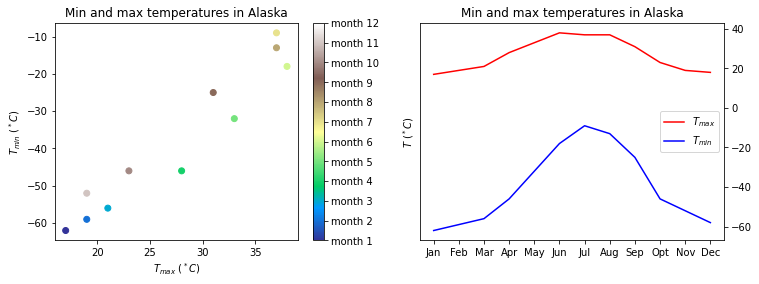

In [3]:
#Define variables

temp_max = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
temp_min = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
months = np.arange(1,13)
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Opt', 'Nov', 'Dec']



#Plot data


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sc1 = ax1.scatter(x = temp_max,y = temp_min, c=months, cmap='terrain')
ax1.set_title('Min and max temperatures in Alaska')
ax1.set_xlabel('$T_{max} \ (^*C)$')
ax1.set_ylabel('$T_{min} \ (^*C)$')
plt.colorbar(sc1, ax = ax1, format='month %d', ticks = np.arange(1,13))

ax2.plot(MONTHS, temp_max, color = 'red', label = '$T_{max}$')
ax2.plot(MONTHS, temp_min, color = 'blue', label = '$T_{min}$')
ax2.set_title('Min and max temperatures in Alaska')
ax2.set_ylabel('$T \ (^*C)$')
ax2.yaxis.tick_right()
ax2.legend()

fit_max params: A = -10.55, omega = 0.69, phi = 0.00, b = 28.87
fit_max params: A = 25.15, omega = -5.68, phi = 47.55, b = -36.71


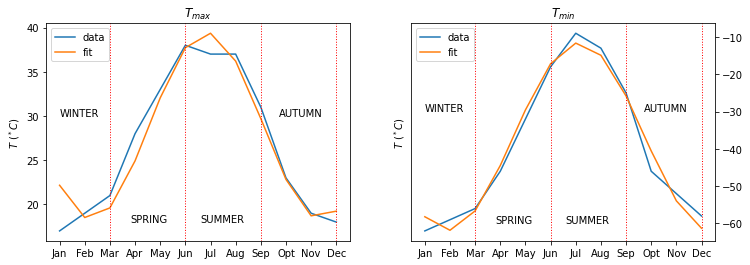

In [4]:
#Define fit functions. The form of f(T) looks like a sinusoid profile, (we also know that the same months over consecutive years are likely to ha ve similar temperatures). Let us try fitting data with such a function

def f1(x, A = 1., omega = 1/12, b = 0.):   #firts possible fit: no phase inside sin function
    g = A*np.sin(omega*x) + b
    return g

def f2(x, A = 1., omega = 1/12, phi = 0., b = 0.):  #second possible fit: phase inside
    g = A*np.sin(omega*x + phi) + b
    return g

def fit(f,x,y):
    fit = sco.curve_fit(f, x, y)
    return fit

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

fit_max, _ = fit(f1,months,temp_max)
ax1.set_title('$T_{max}$')
ax1.plot(MONTHS,temp_max, label = 'data')
ax1.plot(f1(months, fit_max[0], fit_max[1], fit_max[2]), label = 'fit')
ax1.set_ylabel('$T \ (^*C)$')
ax1.legend()
ax1.axvline(2, linestyle = ':', color = 'red', linewidth = 1)
ax1.text(0,30,'WINTER', color = 'black', fontsize=10)
ax1.axvline(5, linestyle = ':', color = 'red', linewidth = 1)
ax1.text(2.8,18,'SPRING', color = 'black', fontsize=10)
ax1.axvline(8, linestyle = ':', color = 'red', linewidth = 1)
ax1.text(5.6,18,'SUMMER', color = 'black', fontsize=10)
ax1.axvline(11, linestyle = ':', color = 'red', linewidth = 1)
ax1.text(8.7,30,'AUTUMN', color = 'black', fontsize=10)
print('fit_max params: A = %.2f, omega = %.2f, phi = 0.00, b = %.2f' % (fit_max[0],fit_max[1],fit_max[2]))


fit_min, _ = fit(f2,months,temp_min)
ax2.set_title('$T_{min}$')
ax2.plot(MONTHS,temp_min, label = 'data')
ax2.plot(f2(months, fit_min[0], fit_min[1], fit_min[2], fit_min[3]), label = 'fit')
ax2.set_ylabel('$T \ (^*C)$')
ax2.yaxis.tick_right()
ax2.legend()
ax2.axvline(2, linestyle = ':', color = 'red', linewidth = 1)
ax2.text(0,-30,'WINTER', color = 'black', fontsize=10)
ax2.axvline(5, linestyle = ':', color = 'red', linewidth = 1)
ax2.text(2.8,-60,'SPRING', color = 'black', fontsize=10)
ax2.axvline(8, linestyle = ':', color = 'red', linewidth = 1)
ax2.text(5.6,-60,'SUMMER', color = 'black', fontsize=10)
ax2.axvline(11, linestyle = ':', color = 'red', linewidth = 1)
ax2.text(8.7,-30,'AUTUMN', color = 'black', fontsize=10)

print('fit_max params: A = %.2f, omega = %.2f, phi = %.2f, b = %.2f' % (fit_min[0],fit_min[1],fit_min[2],fit_min[3]))

Let us have a look at the outputs: the first graph depicts the trend of temperatures quite well, even though using a periodic function results in evident raises at the edges that do not match the data. On the other hand, the second image shows a fit that follows perfectly the profile of minimal temperatures over the whole year. The result looks reasonable and its prevision are in accordance to what one might expect from direct experience: temperatures are expected to be closer to steady during summer (high) and winter (low) and therefore reach the max (min, respectively) during those seasons. Sping and autumn depict instead a quite consistent growth (fall) of temperatures. While the model works good to find an overall prediction for each month, it fails to find the correct absolute minima: this is mainly because of the rising slopes for at the edges of the dataset. Moreover, the predicted value for the maximal temperature in July is expected to be the highest of the whole year, while actual data present a decrease. Indeed, the model indicates correctly the less cold month of the year (July as well).

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


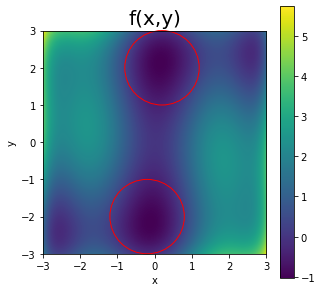

Looking at the image above, the apparently darkest regions, expected to locate the minima in the range set, are inside the red circles (with centers in (0.2,2) and (-0.2,2))

Let us look at the scikit minimizer:

Result of minimization with starting guess (0.2,2): Optimization terminated successfully.
Minimum found: f([-0.08984208  0.71265674]) = -1.0316284534889568

Result of minimization with starting guess (-0.2,-2): Optimization terminated successfully.
Minimum found: f([ 0.08984206 -0.71265675]) = -1.0316284534888749

The two minimization processes lead to two global minima in the region under analysis: even though the minimum values are slightly different, the argmins found by the algorithm are symmetric w.r.t. the origin of x,y (as we expect, since we have that f(x,y) = f(-x,-y))
We can see that such minima fall outside the previous red circles. Nevertheless, the algorithm successfully converges.
The computation was repeated with CG, COBYLA and TNC methods, other than the defaul

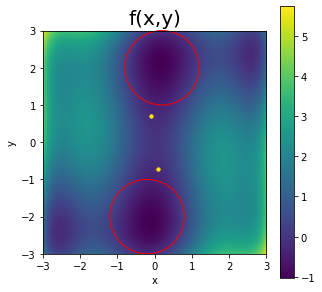

In [9]:
#Define function to analyse

def f(data):
    x, y = data
    f = (4.-2.1*x**2 + (1./3.)*x**4)*x**2 + x*y + (4.*y**2-4.)*y**2
    return f

#Define grid
x = np.arange(-2, 2, 0.01)
y = np.arange(-1, 1, 0.01)
X, Y = np.meshgrid(x, y, sparse=True)
data = X,Y

#Plot

fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
h = ax.imshow(f(data), extent=[-3, 3, -3, 3])
plt.colorbar(h, ax = ax)
ax.set_title('f(x,y)', fontsize = 20)
ax.set_xlabel('x')
ax.set_ylabel('y')
ell1 = pltp.Ellipse((0.2, 2), 2, 2, color='r', clip_on=False, fill=False)
ell2 = pltp.Ellipse((-0.2, -2), 2, 2, color='r', clip_on=False, fill=False)
ax.add_artist(ell1)
ax.add_artist(ell2)
plt.show()

print('Looking at the image above, the apparently darkest regions, expected to locate the minima in the range set, are inside the red circles (with centers in (0.2,2) and (-0.2,2))')


#Auto minimization
print('\nLet us look at the scikit minimizer:')
res1 = sco.minimize(f, (0.2,2))
print('\nResult of minimization with starting guess (0.2,2):', res1.message)
print('Minimum found: f({}) = {}'.format(res1.x, res1.fun))

res2 = sco.minimize(f, (-0.2,-2))
print('\nResult of minimization with starting guess (-0.2,-2):', res2.message)
print('Minimum found: f({}) = {}'.format(res2.x, res2.fun))

print('\nThe two minimization processes lead to two global minima in the region under analysis: even though the minimum values are slightly different, the argmins found by the algorithm are symmetric w.r.t. the origin of x,y (as we expect, since we have that f(x,y) = f(-x,-y))')
print('We can see that such minima fall outside the previous red circles. Nevertheless, the algorithm successfully converges.')
print('The computation was repeated with CG, COBYLA and TNC methods, other than the default one. The results are plotted as yellow dots in the graph below: as we can see no difference in the found minima is noticeable between those specific methods.')

#Let us try some other methods...
res11 = sco.minimize(f, (0.2,2), method = 'CG')
res12 = sco.minimize(f, (0.2,2), method = 'COBYLA')
res13 = sco.minimize(f, (0.2,2), method = 'TNC')
res21 = sco.minimize(f, (-0.2,-2), method = 'CG')
res22 = sco.minimize(f, (-0.2,-2), method = 'COBYLA')
res23 = sco.minimize(f, (-0.2,-2), method = 'TNC')


fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
h = ax.imshow(f(data), extent=[-3, 3, -3, 3])
plt.colorbar(h, ax = ax)
ax.set_title('f(x,y)', fontsize = 20)
ax.set_xlabel('x')
ax.set_ylabel('y')
ell1 = pltp.Ellipse((0.2, 2), 2, 2, color='r', clip_on=False, fill=False)
ell2 = pltp.Ellipse((-0.2, -2), 2, 2, color='r', clip_on=False, fill=False)
ax.add_artist(ell1)
ax.add_artist(ell2)
ax.plot(res1.x[0], res1.x[1], markerfacecolor='yellow', markeredgecolor='gold', marker='o', markersize=3, alpha=0.6)
ax.plot(res11.x[0], res11.x[1], markerfacecolor='yellow', markeredgecolor='gold', marker='o', markersize=3, alpha=0.6)
ax.plot(res12.x[0], res12.x[1], markerfacecolor='yellow', markeredgecolor='gold', marker='o', markersize=3, alpha=0.6)
ax.plot(res13.x[0], res13.x[1], markerfacecolor='yellow', markeredgecolor='gold', marker='o', markersize=3, alpha=0.6)
ax.plot(res2.x[0], res2.x[1], markerfacecolor='yellow', markeredgecolor='gold', marker='o', markersize=3, alpha=0.6)
ax.plot(res21.x[0], res21.x[1], markerfacecolor='yellow', markeredgecolor='gold', marker='o', markersize=3, alpha=0.6)
ax.plot(res22.x[0], res22.x[1], markerfacecolor='yellow', markeredgecolor='gold', marker='o', markersize=3, alpha=0.6)
ax.plot(res23.x[0], res23.x[1], markerfacecolor='yellow', markeredgecolor='gold', marker='o', markersize=3, alpha=0.6)
plt.show()

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

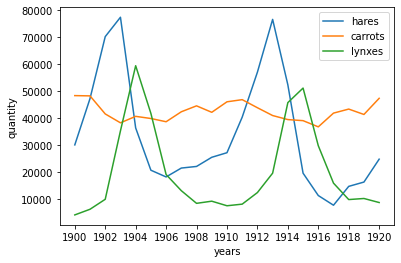

The graph above depicts a clearly periodic trend of the three populations (an original analysis of this has already been made in my 03ex file).
Let us go into further detail with such analysis using FFTs:


In [6]:
a = np.loadtxt('populations.txt')   #import file

years = a[:,0]         #create arrays
hares = a[:,1]
lynxes = a[:,2]
carrots = a[:,3]
classes = [hares,carrots,lynxes]


plt.plot(years,hares,label='hares')                   #plot instructions
plt.plot(years,carrots,label='carrots')
plt.plot(years,lynxes,label='lynxes')
plt.legend()
plt.xticks(np.arange(years[0], years[-1]+1, 2.0))
plt.xlabel('years')
plt.ylabel('quantity')
plt.show()

print('The graph above depicts a clearly periodic trend of the three populations (an original analysis of this has already been made in my 03ex file).')
print('Let us go into further detail with such analysis using FFTs:')


[ 715700.             -0.j          -12514.06952825 -41299.48433234j
   89297.43358494-255500.90418033j    5643.5575706   +2259.99350585j
 -129841.66607374 -17562.14622119j   -4257.74760585  +7223.49741538j
    3414.51546035 +51911.05349609j    5150.          +1472.24318643j
   23362.87388516  -8859.63776904j   -3958.07303095  +3108.04669839j
  -19146.82426226 -12426.36232831j  -19146.82426226 +12426.36232831j
   -3958.07303095  -3108.04669839j   23362.87388516  +8859.63776904j
    5150.          -1472.24318643j    3414.51546035 -51911.05349609j
   -4257.74760585  -7223.49741538j -129841.66607374 +17562.14622119j
    5643.5575706   -2259.99350585j   89297.43358494+255500.90418033j
  -12514.06952825 +41299.48433234j]


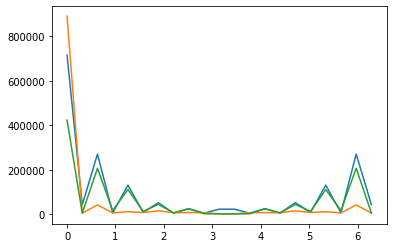

In [7]:
#Let us perform fft on the variables of dataset:

F_hares = scf.fft(hares)
F_carrots = scf.fft(carrots)
F_lynxes = scf.fft(lynxes)

#Set frequency discrete domain:

omega = np.linspace(0,2*np.pi,len(F_hares))

#Plot ffts and compare results:
plt.plot(omega,abs(F_hares))
plt.plot(omega,abs(F_carrots))
plt.plot(omega,abs(F_lynxes))

print('It is noticeable that in a range of 2π')

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

Original pic:


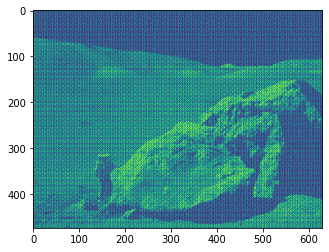


Fourier transform:


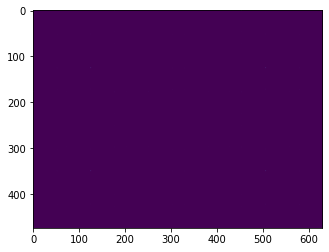


I cannot see anything. The color of each element is equal to the others. Calculating the absolut value of each element of fft, theydeem to have the same value.

Plotting the log of the norm of fft elements:


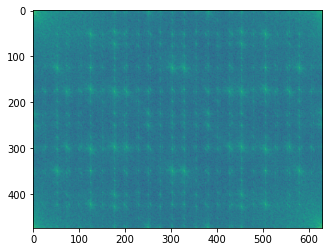

We can see that some elements are actually different from the others and present a pattern in the fft. Let us try to remove the noise.

Cleared image: (p=0.5)


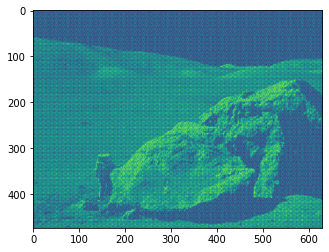


Cleared image: (p=0.7)


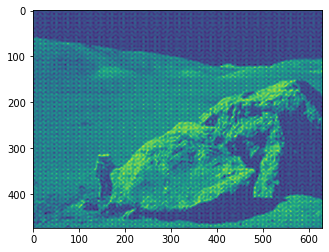


Cleared image: (p=0.8)


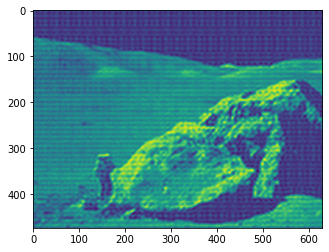


Cleared image: (p=0.9)


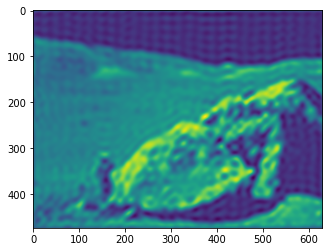


Cleared image: (p=0.99)


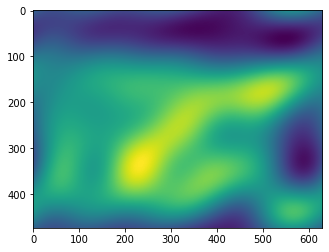

The best looking image looks like the one with p=80% of high frequencies removed. Let us compare the result with the original:


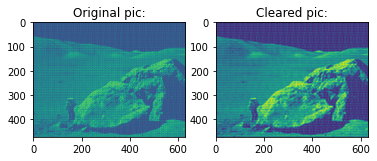

Which looks slightly better.


In [62]:
#load image:
import pylab

image = pylab.imread("moonlanding.png")
print('Original pic:')
pylab.imshow(image)
pylab.show()

ft = scf.fft2(image)
print('\nFourier transform:')
pylab.imshow(np.abs(ft))
pylab.show()
print('\nI cannot see anything. The color of each element is equal to the others. Calculating the absolut value of each element of fft, theydeem to have the same value.')

print('\nPlotting the log of the norm of fft elements:')
pylab.imshow(np.log(np.abs(ft)))
pylab.show()
print('We can see that some elements are actually different from the others and present a pattern in the fft. Let us try to remove the noise.')


#As I have understood, higher frequencies' coeffs occupy the most central slots of fft2, therefore:

pta = [0.50, 0.70,0.80, 0.90, 0.99]      # percetage_to_annihilate
x = ft.shape[0]
y = ft.shape[1]
gridsize = (1, 2)

for p in pta:
    x_bond = int(x*p/2)
    y_bond = int(y*p/2)
    ft[int(x/2)-x_bond:int(x/2)+x_bond] = 0
    ft[:,int(y/2)-y_bond:int(y/2)+y_bond] = 0    #annihilate all elements in a range of x*p and y*p (I have seen in a tutorial that low frequencies are on the corners)
    print('\nCleared image: (p={})'.format(p))
    ift = scf.ifft2(ft)
    pylab.imshow(ift.real)
    pylab.show()
    

print('The best looking image looks like the one with p=80% of high frequencies removed. Let us compare the result with the original:')


f, axarr = plt.subplots(1,2)
axarr[0].imshow(image)
axarr[0].set_title('Original pic:')

ft = scf.fft2(image)
p = 0.80
x_bond = int(x*p/2)
y_bond = int(y*p/2)
ft[int(x/2)-x_bond:int(x/2)+x_bond] = 0
ft[:,int(y/2)-y_bond:int(y/2)+y_bond] = 0
ift = scf.ifft2(ft)
axarr[1].set_title('Cleared pic:')
axarr[1].imshow(ift.real)
pylab.show()
print('Which looks slightly better.')